In [33]:
import os
import sys
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import yaml
from tqdm import tqdm
import torch
import SimpleITK as sitk
import gc
import psutil
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch
from monai.transforms import (
    Compose,
    AsDiscrete,
    AddChannel,
    EnsureType,
    EnsureTyped,
    AsDiscreted,
)
from pandas import DataFrame
from monai.metrics import DiceMetric
sys.path.append('/home/local/VANDERBILT/litz/github/MASILab/lobe_seg')
from luna16_preprocess import get_kfolds
from dataloader import train_dataloader, val_dataloader, test_dataloader
from models import unet256, unet512
from postprocess import get_largest_cc, nearest_label_filling
sys.path.append("/home/local/VANDERBILT/litz/github/MASILab/thoraxtools/func")
from vis import vis
import vis.paral_clip_overlay_mask as overlay

In [42]:
root_dir = "/home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/"
label_dir = "/home/local/VANDERBILT/litz/data/luna16/fixed_labels/"
# root_dir = "/home/local/VANDERBILT/litz/data/luna16/preproc_qa"
# scanid = "1.3.6.1.4.1.14519.5.2.1.6279.6001.281967919138248195763602360723"
scanid = "1.3.6.1.4.1.14519.5.2.1.6279.6001.416701701108520592702405866796"
img_sitk = sitk.ReadImage(os.path.join(root_dir, f"{scanid}.nii.gz"))
img = sitk.GetArrayFromImage(img_sitk)
label_sitk = sitk.ReadImage(os.path.join(label_dir, f"{scanid}_LobeSegmentation.nrrd"))
label_img = sitk.GetArrayFromImage(label_sitk)
img_nib = nib.load(os.path.join(root_dir, f"{scanid}.nii.gz"))
img_nib_img = label_nib.get_fdata()

In [35]:
def showslice(img, z, y, x, is_gray=False, clip_range=[]):
    clip_ax = img[z, :, :]
    clip_cor = img[:,y,:]
    clip_cor = np.flip(clip_cor, 0)
    clip_sag = img[:,:,x]
    clip_sag = np.flip(clip_sag, 0)
    if len(clip_range) > 0:
        vmin = clip_range[0]
        vmax = clip_range[1]
    else:
        vmax = np.max(img)
        vmin = np.min(img)
    # fig = plt.figure(1)
    f, ax = plt.subplots(1, 3, figsize=(15, 15))
    if is_gray:
        ax[0].imshow(clip_ax, interpolation='nearest', cmap='gray', vmin=vmin, vmax=vmax)
        ax[1].imshow(clip_cor, interpolation='nearest', cmap='gray', vmin=vmin, vmax=vmax)
        sag = ax[2].imshow(clip_sag, interpolation='nearest', cmap='gray', vmin=vmin, vmax=vmax)
        
    else:
        ax[0].imshow(clip_ax, interpolation='nearest', vmin=vmin, vmax=vmax)
        ax[1].imshow(clip_cor, interpolation='nearest', vmin=vmin, vmax=vmax)
        sag = ax[2].imshow(clip_sag, interpolation='nearest', vmin=vmin, vmax=vmax)
    plt.colorbar(sag, ax=ax[2], fraction=0.046, pad=0.04)


(277, 512, 512)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512 277   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.       0.878906 0.878906 1.25     0.       0.       0.       0.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : unknown
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x   

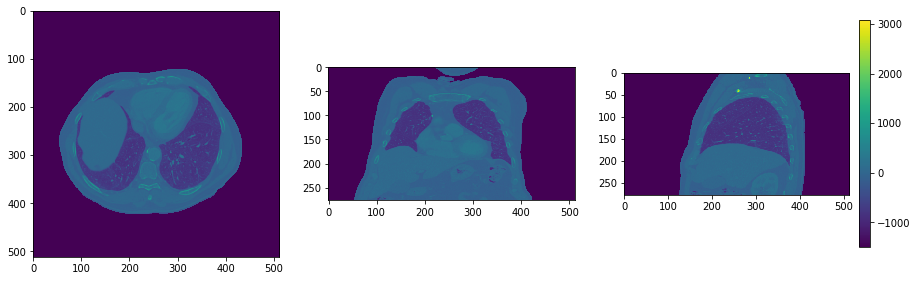

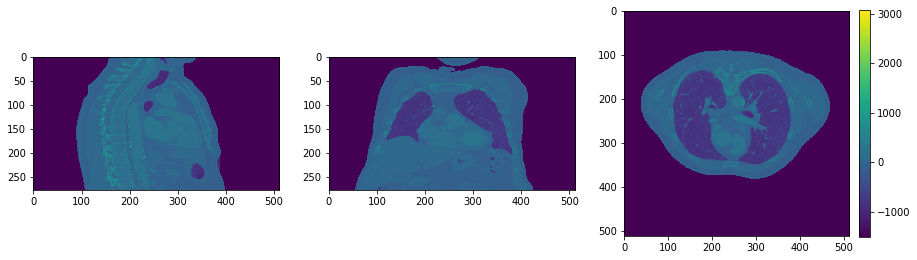

In [44]:
print(img.shape)
print(img_sitk.GetDirection())
print(img_nib.header)
showslice(img, 100,200,150)
vis.showslice(img_nib_img, 250,200,150)

In [4]:
CONFIG_DIR = "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/configs"
def load_config(config_name, config_dir):
    with open(os.path.join(config_dir, config_name)) as file:
        config = yaml.load(file, Loader=yaml.FullLoader)
    return config
config_id = "0511cval"
config = load_config(f"Config_{config_id}.YAML", CONFIG_DIR)

k = 1
MODEL_DIR = os.path.join(config["model_dir"], config_id, f"fold{k}")
model_path = os.path.join(MODEL_DIR, f"{config_id}_best_model.pth")

# Load data
images = get_kfolds(config["kfolds_path"])
test_images = images[k-1]
test_loader, invert_transforms = test_dataloader(config, test_images)

# Initialize Model and test metric
device = torch.device("cuda:0")
if config["model"] == 'unet512':
    model = unet512(6).to(device)
elif config["model"] == 'unet1024':
    model = unet1024(6).to(device)
else:
    model = unet256(6).to(device)
# Set metric to compute average over each class
test_metric = DiceMetric(include_background=False, reduction="none")
device = torch.device(config["device"])
model.load_state_dict(torch.load(model_path))
model.eval()
post_pred_transforms = Compose([
    EnsureTyped(keys=["label", "pred"]),
    AsDiscreted(keys="pred", argmax=True, to_onehot=6),
    AsDiscreted(keys="label", to_onehot=6)
])
measure_transforms = Compose([EnsureType(), AddChannel(), AsDiscrete(to_onehot=6)])
image_paths = []
loader = iter(test_loader)

In [ ]:
with torch.no_grad():
    test_data = next(iter(test_loader))
    # for test_data in tqdm(test_loader):
    test_inputs, label, image_path = (
        test_data["image"].to(device),
        test_data["label"][0, 0, :, :, :].detach().cpu().numpy(),
        test_data["image_path"][0]
    )
    image_paths.append(image_path)
    test_data["pred"] = sliding_window_inference(test_inputs, config["crop_shape"], 4, model)
    test_data = [post_pred_transforms(i) for i in decollate_batch(test_data)]
    test_data = test_data[0]
    # postprocces with CC and nearest label filling
    postprocess = torch.argmax(test_data["pred"], dim=0)
    postprocess = postprocess.detach().cpu().numpy()
    postprocess = nearest_label_filling(postprocess, get_largest_cc(postprocess))
    test_data["pred"] = measure_transforms(postprocess)
    #
    # print(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)
    # accumulate dice
    test_metric(y_pred=[test_data["pred"]], y=[test_data["label"]])
    # dice of this example's RML
    rml_dice = test_metric.aggregate()[-1][3]

In [5]:
test_data = next(loader)
test_inputs, label, image_path = (
    test_data["image"].to(device),
    test_data["label"][0, 0, :, :, :].detach().cpu().numpy(),
    test_data["image_path"][0]
)
print(image_path)
print(label.shape)

/home/local/VANDERBILT/litz/data/luna16/preproc_qa/1.3.6.1.4.1.14519.5.2.1.6279.6001.183843376225716802567192412456.mhd
(429, 301, 331)


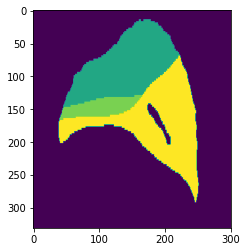

In [10]:
def clip_image(image_data, clip_plane, num_clip=1, idx_clip=0):
    im_shape = image_data.shape

    # Get clip offset
    idx_dim = -1
    if clip_plane == 'sagittal':
        idx_dim = 0
    elif clip_plane == 'coronal':
        idx_dim = 1
    elif clip_plane == 'axial':
        idx_dim = 2
    else:
        raise NotImplementedError

    clip_step_size = int(float(im_shape[idx_dim]) / (num_clip + 1))
    offset = -int(float(im_shape[idx_dim]) / 2) + (idx_clip + 1) * clip_step_size

    clip_location = int(im_shape[idx_dim] / 2) - 1 + offset

    clip = None
    if clip_plane == 'sagittal':
        clip = image_data[-clip_location, :, :]
        clip = np.flip(clip, 0)
        clip = np.rot90(clip)
    elif clip_plane == 'coronal':
        clip = image_data[:, clip_location, :]
        clip = np.rot90(clip)
        clip = np.flip(clip, 1)
    elif clip_plane == 'axial':
        clip = image_data[:, :, clip_location]
        clip = np.rot90(clip)
        clip = np.flip(clip, 1)
    else:
        raise NotImplementedError

    return clip

ax_clip = clip_image(label, "sagittal", 16, 5)
f, ax = plt.subplots(1,1)
ax.imshow(ax_clip)

0